In [1]:
from datetime import date, datetime, timedelta
import statistics
import numpy as np
import pandas as pd
from scipy.stats import pearsonr, f_oneway, ttest_ind
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn import ensemble
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, ParameterGrid, RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVR, LinearSVR
from sklearn.neural_network import MLPRegressor
import seaborn as sns
import xgboost as xgb
import joblib

In [2]:
#import data
data = pd.read_csv('~/python_files/sp_high_speed_rail.csv')

In [3]:
# explore data
print(data.dtypes)
data.head()

Unnamed: 0       int64
insert_date     object
origin          object
destination     object
start_date      object
end_date        object
train_type      object
price          float64
train_class     object
fare            object
dtype: object


,Unnamed: 0,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,0,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo
1,1,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:00:00,2019-05-29 09:32:00,AVE,53.40,Turista,Promo
2,2,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:30:00,2019-05-29 09:51:00,AVE,47.30,Turista,Promo
3,3,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 08:00:00,2019-05-29 10:32:00,AVE,69.40,Preferente,Promo
4,4,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 08:30:00,2019-05-29 11:14:00,ALVIA,NaN,Turista,Promo


In [4]:
# Drop unneeded trip ID column
data.drop(['Unnamed: 0', 'insert_date'], axis='columns', inplace=True)

In [5]:
data.tail()

,origin,destination,start_date,end_date,train_type,price,train_class,fare
2579766,MADRID,SEVILLA,2019-05-30 19:00:00,2019-05-30 21:38:00,AVE,76.30,Turista,Flexible
2579767,MADRID,SEVILLA,2019-05-30 19:30:00,2019-05-30 22:05:00,AVE,76.30,Turista,Flexible
2579768,MADRID,SEVILLA,2019-05-30 20:00:00,2019-05-30 22:21:00,AVE,72.30,Turista Plus,Promo
2579769,MADRID,SEVILLA,2019-05-30 20:35:00,2019-05-30 23:15:00,AVE,76.30,Turista,Flexible
2579770,MADRID,SEVILLA,2019-05-30 21:25:00,2019-05-31 00:10:00,AV City,49.15,Turista,Promo


In [6]:
#all other columns are object data, so let's describe the price column.
data.price.describe()

count    2.269090e+06
mean     6.338550e+01
std      2.578319e+01
min      1.545000e+01
25%      4.375000e+01
50%      6.030000e+01
75%      7.880000e+01
max      2.142000e+02
Name: price, dtype: float64

Looks like we are missing some rows, so we'll have to address that.

In [7]:
#perform any manipulations to fix the data for modeling
#Check unique values and NaNs for each column, excluding the trip ID column
for col in data.columns:
    column = data[col]
    print('column:', col)
    print('unique vals:', column.nunique())
    print('nan vals:', column.isnull().sum())
    print()

column: origin
unique vals: 5
nan vals: 0

column: destination
unique vals: 5
nan vals: 0

column: start_date
unique vals: 8090
nan vals: 0

column: end_date
unique vals: 10736
nan vals: 0

column: train_type
unique vals: 16
nan vals: 0

column: price
unique vals: 225
nan vals: 310681

column: train_class
unique vals: 6
nan vals: 9664

column: fare
unique vals: 7
nan vals: 9664



It's looking like we have some clear candidates for creating dummy variables (origin, destination, train_type, train_class, and fare). We can also turn the start_date and end_date into useful variables by subtracting to get a trip duration, and possibly making dummy columns for day of week or time of day (morning, midday, night). But first, let's look into the null values.

### Addressing Nan values

Our train_class and fare columns have the same number of Nan values. Do they occur in the same rows?

In [8]:
nas = data[data['fare'].isna()]
nas[~nas['train_class'].isna()]

,origin,destination,start_date,end_date,train_type,price,train_class,fare


They completely overlap. And is there any overlap with the price column Nan values?

In [9]:
nas[~nas['price'].isna()]

,origin,destination,start_date,end_date,train_type,price,train_class,fare


There is! Because all three rows share their Nans, and price is our target, removing all rows with Nan prices will take care of our problem.

In [10]:
data = data[data['price'].notnull()]
data.shape[0]

2269090

And we still have a huge amount of data to work with.

Now, to create some kind of useful data from our start_date and end_date columns, let's calculate a "trip_duration" column by subtracting start from end.

In [11]:
# A column with trip durations would perhaps be more helpful than the start and end dates. 
# Probably best formatted in seconds.
data['start_date'] = pd.to_datetime(data['start_date'])
data['end_date'] = pd.to_datetime(data['end_date'])
data['trip_duration'] = (data['end_date'] - data['start_date'])/np.timedelta64(1, 's')
data.head()

,origin,destination,start_date,end_date,train_type,price,train_class,fare,trip_duration
0,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo,10560.0
1,MADRID,SEVILLA,2019-05-29 07:00:00,2019-05-29 09:32:00,AVE,53.40,Turista,Promo,9120.0
2,MADRID,SEVILLA,2019-05-29 07:30:00,2019-05-29 09:51:00,AVE,47.30,Turista,Promo,8460.0
3,MADRID,SEVILLA,2019-05-29 08:00:00,2019-05-29 10:32:00,AVE,69.40,Preferente,Promo,9120.0
5,MADRID,SEVILLA,2019-05-29 09:00:00,2019-05-29 11:38:00,AVE,60.30,Turista,Promo,9480.0


# Visualizations

Time to begin visually inspecting our data. For starters let's check out our numeric variables, both univariate and bivariate.

### Numeric predictors: trip_duration and price

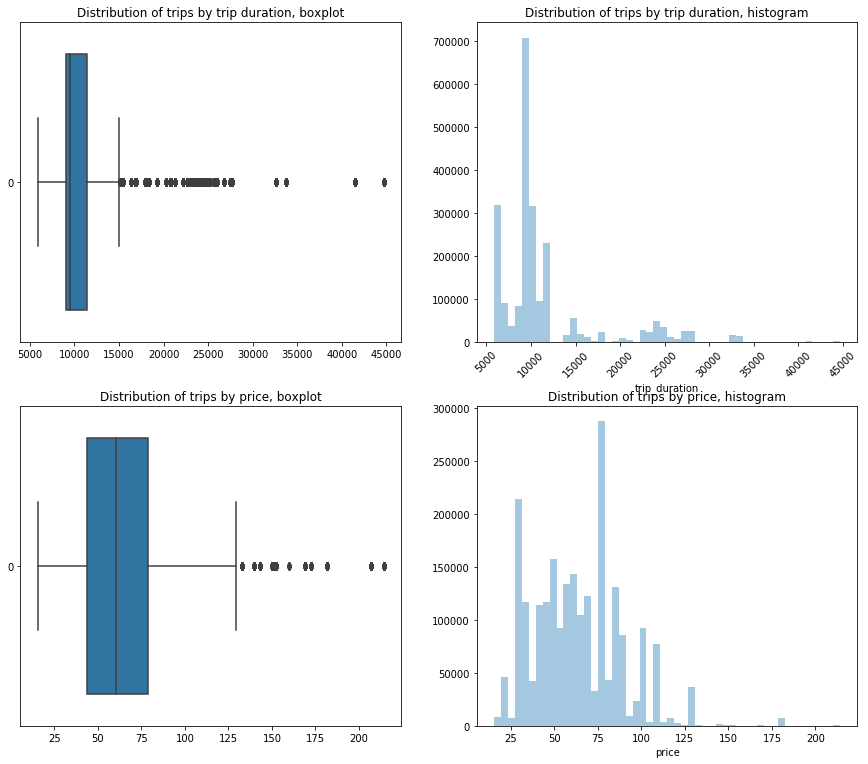

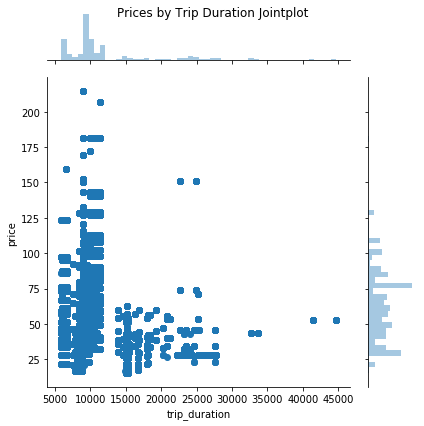

Correlation Coefficient and p-value:


(-0.2967237585821424, 0.0)

In [14]:
#Visually explore the data. Begin here with univariate analysis
plt.figure(figsize=(15, 20))

plt.subplot(3, 2, 1)
sns.boxplot(data=data.trip_duration, orient='h')
plt.title('Distribution of trips by trip duration, boxplot')

plt.subplot(3, 2, 2)
sns.distplot(data.trip_duration, kde=False)
plt.title('Distribution of trips by trip duration, histogram')
plt.xticks(rotation=45)

plt.subplot(3, 2, 3)
sns.boxplot(data=data.price, orient='h')
plt.title('Distribution of trips by price, boxplot')

plt.subplot(3, 2, 4)
sns.distplot(data.price, kde=False)
plt.title('Distribution of trips by price, histogram')

#plt.subplot(3, 2, 5)
sns.jointplot(x='trip_duration', y='price', data=data)
plt.suptitle('Prices by Trip Duration Jointplot')

plt.tight_layout()
plt.show()

print('Correlation Coefficient and p-value:')
pearsonr(data.trip_duration, data.price)

From the upper plots we can see that both trip_duration and price have right skewed distributions, though considering the size of the data set, price looks much closer to normal.

There are many outliers for trip_duration and a few for price. For now, these are acceptable, again, due to the size of the data set and because we are curious about predicting all tickets for the range of prices.

From the bivariate plot we can see a rough curve to the data that looks reminiscent of an inverse relationship, with a few outliers in the center.

A Pearson's Correlation Coefficient shows a weak negative linear relationship, as expected from the bivariate plot. Due to the skewed nature of these two columns of data, especially price, this is understandable. Because we're working with more advanced models and many predictors, I will leave these for now and continue analysis.

### Categorical predictors: origin, destination, train_type, train_class, and fare

### Origin city:

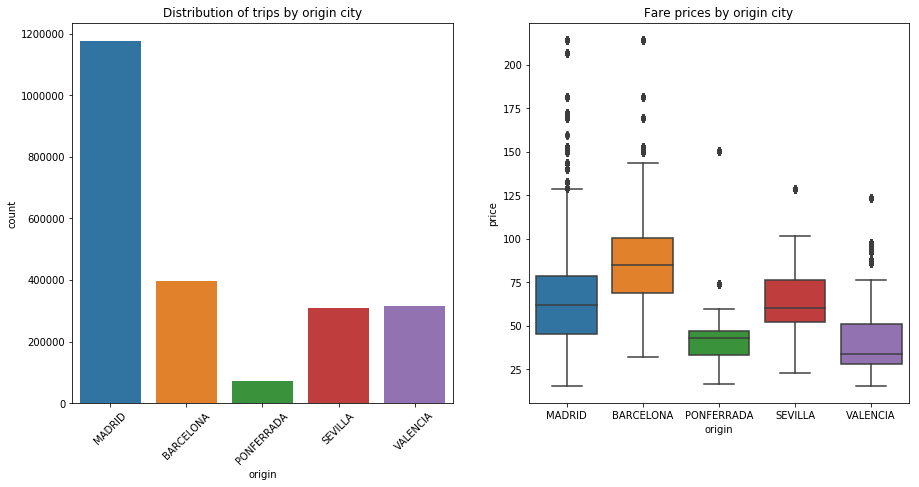

ANOVA test f-statistic and p-value:


F_onewayResult(statistic=196350.87934270225, pvalue=0.0)

In [15]:
# Plot origin distplot and origin vs price multiple boxplot
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
sns.countplot(x='origin', data=data, order=['MADRID', 'BARCELONA', 'PONFERRADA', 'SEVILLA', 'VALENCIA'])
plt.title('Distribution of trips by origin city')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x='origin', y='price', data=data, order=['MADRID', 'BARCELONA', 'PONFERRADA', 'SEVILLA', 'VALENCIA'])
plt.title('Fare prices by origin city')
plt.show()

print('ANOVA test f-statistic and p-value:')
f_oneway(data[data['origin']=='MADRID']['price'],
        data[data['origin']=='BARCELONA']['price'],
        data[data['origin']=='PONFERRADA']['price'],
        data[data['origin']=='SEVILLA']['price'],
        data[data['origin']=='VALENCIA']['price'])

We can see that Madrid departures account for nearly half of the fares in our data, with the widest range of prices as well. Given the nearly 1.2 million fares for Madrid, the outliers seen on the boxplot seem acceptable to me. The same with all the others, as well. Barcelona, with the second highest number of departures, has much higher median 
ticket prices than the rest of the origin cities and similar outliers as Madrid.

The ANOVA test confirms what we can see visually - we would have to reject the null hypothesis that the means are consistent across all values of the 'origin' column. 

### Destination City:

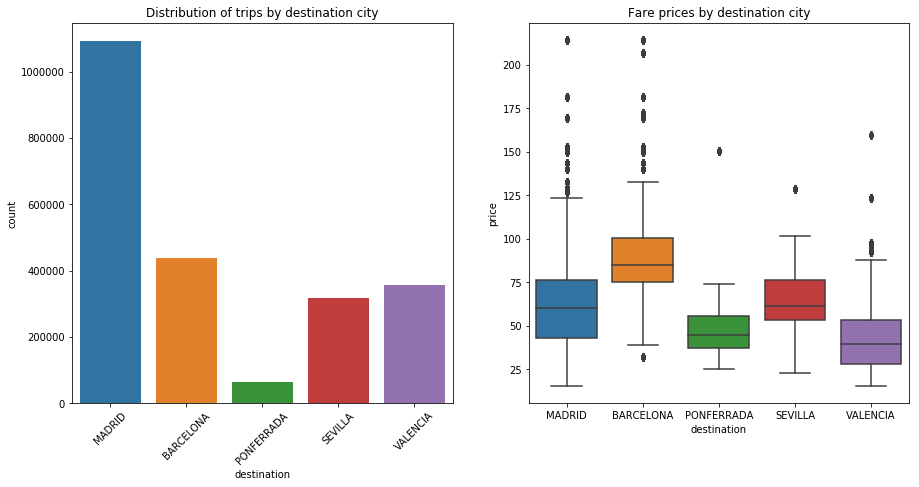

ANOVA test f-statistic and p-value:


F_onewayResult(statistic=206932.33538192467, pvalue=0.0)

In [16]:
# Plot destination distplot and origin vs price multiple boxplot
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
sns.countplot(x='destination', data=data, order=['MADRID', 'BARCELONA', 'PONFERRADA', 'SEVILLA', 'VALENCIA'])
plt.title('Distribution of trips by destination city')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x='destination', y='price', data=data, order=['MADRID', 'BARCELONA', 'PONFERRADA', 'SEVILLA', 'VALENCIA'])
plt.title('Fare prices by destination city')
plt.show()

print('ANOVA test f-statistic and p-value:')
f_oneway(data[data['destination']=='MADRID']['price'],
        data[data['destination']=='BARCELONA']['price'],
        data[data['destination']=='PONFERRADA']['price'],
        data[data['destination']=='SEVILLA']['price'],
        data[data['destination']=='VALENCIA']['price'])

These plots appear very similar to those of 'origin', with Madrid having the highest number of trips, but Barcelona having the highest median fare price. Outliers exist for all categories, but aren't a huge concern as we have so many data points.

Again, the ANOVA test tells us that our means are not the same across the values of 'destination.'

### Train Type:

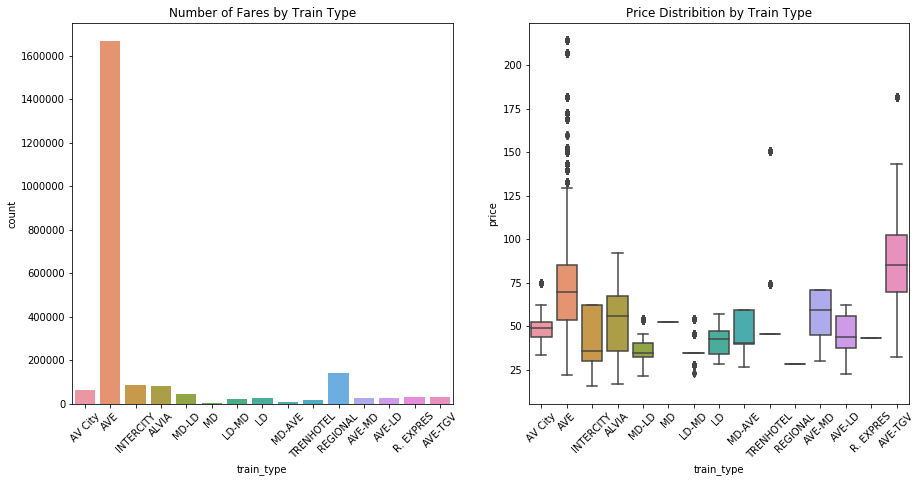

ANOVA test f-statistic and p-value:


F_onewayResult(statistic=62765.067208457076, pvalue=0.0)

In [17]:
# Plot train_type distplot and boxplot against price
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
sns.countplot(x='train_type', data=data)
plt.title('Number of Fares by Train Type')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x='train_type', y='price', data=data)
plt.title('Price Distribition by Train Type')
plt.xticks(rotation=45)
plt.show()

print('ANOVA test f-statistic and p-value:')
f_oneway(data[data['train_type']=='AV City']['price'],
        data[data['train_type']=='AVE']['price'],
        data[data['train_type']=='INTERCITY']['price'],
        data[data['train_type']=='ALVIA']['price'],
        data[data['train_type']=='MD-LD']['price'],
        data[data['train_type']=='MD']['price'],
        data[data['train_type']=='LD-MD']['price'],
        data[data['train_type']=='LD']['price'],
        data[data['train_type']=='MD-AVE']['price'],
        data[data['train_type']=='TRENHOTEL']['price'],
        data[data['train_type']=='REGIONAL']['price'],
        data[data['train_type']=='AVE-MD']['price'],
        data[data['train_type']=='AVE-LD']['price'],
        data[data['train_type']=='R. EXPRES']['price'],
        data[data['train_type']=='AVE-TGV']['price'],)

AVE appears as the most prominent in the train_type category with over 1.6 million trips. As with previous plots, our most common category also has the widest distribution of prices with many outliers. We also see in our boxplot that AVE and AVE-TGV have higher median prices than the rest of the train types. While AVE likely serves all fare classes (economy, luxury), AVE-TGV may be a more luxurious, faster, or regional train that must charge more.

TRENHOTEL, the second most common train type, has one of the wider price ranges, as well, though it appears to only have 3 distinct pricepoints.

Our ANOVA confirms the observation that the means are not consistent across all train types.

### Train Class:

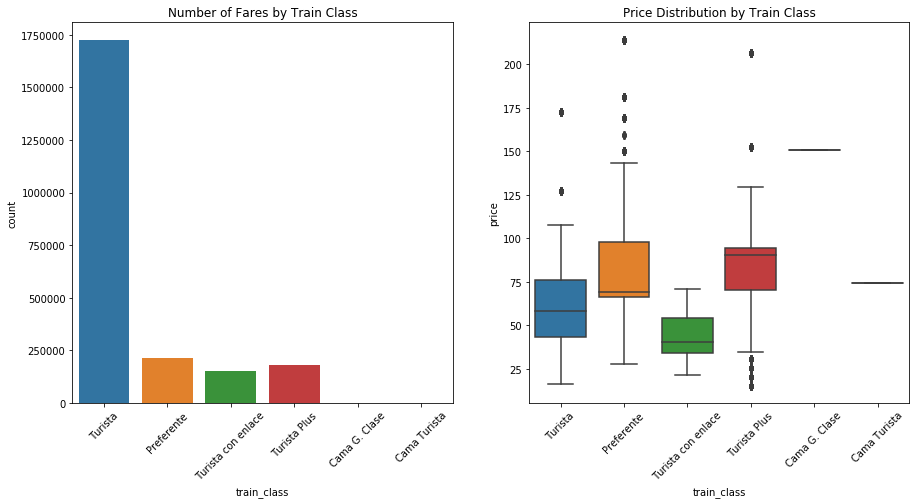

ANOVA test f-statistic and p-value:


F_onewayResult(statistic=76518.49499671294, pvalue=0.0)

In [18]:
# PLot train_class countplot and boxplot with price
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
sns.countplot(x='train_class', data=data)
plt.title('Number of Fares by Train Class')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x='train_class', y='price', data=data)
plt.title('Price Distribution by Train Class')
plt.xticks(rotation=45)
plt.show()

print('ANOVA test f-statistic and p-value:')
f_oneway(data[data['train_class']=='Turista']['price'],
        data[data['train_class']=='Preferente']['price'],
        data[data['train_class']=='Turista con enlace']['price'],
        data[data['train_class']=='Turista Plus']['price'],
        data[data['train_class']=='Cama G. Clase']['price'],
        data[data['train_class']=='Cama Turista']['price'])

Turista class trains account for over 3/4 of the trips, with the second lowest median price per trip. Turista Plus and Preferente have the most outliers. Both of the "Cama" class trains ('bed' in english, sleeper trains) are each a fixed rate and account for very few of the trains as seen on the left plot.

Again the ANOVA test p-value is very low and we can confirm the means are different.

### Fare Type:

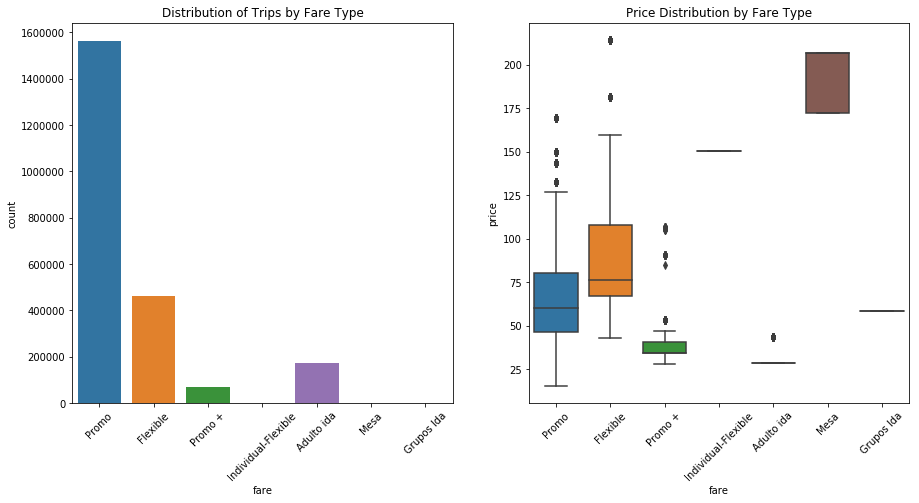

ANOVA test f-statistic and p-value:


F_onewayResult(statistic=132415.14351684504, pvalue=0.0)

In [19]:
# Plot fare type countplot and boxplot w price
plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
sns.countplot(x='fare', data=data)
plt.title('Distribution of Trips by Fare Type')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x='fare', y='price', data=data)
plt.title('Price Distribution by Fare Type')
plt.xticks(rotation=45)
plt.show()

print('ANOVA test f-statistic and p-value:')
f_oneway(data[data['fare']=='Promo']['price'],
        data[data['fare']=='Flexible']['price'],
        data[data['fare']=='Promo +']['price'],
        data[data['fare']=='Individual-Flexible']['price'],
        data[data['fare']=='Adulto ida']['price'],
        data[data['fare']=='Mesa']['price'],
        data[data['fare']=='Grupos Ida']['price'])

In [20]:
data[data['fare']=='Mesa']['price'].unique()

array([172.4, 206.8])

Fares also show similar variation. "Promo" and "Flexible" have wider IQR's with multiple outliers above, "Promo+" has a very small IQR but more outliers. We then come to a few unusual cases: it appears that "Individual-Flexible" and "Grupos Ida" are only single fare tickets, "Adulto ida" gets two values, but predominantly the lower, and "Mesa" fares are only 2 discrete values, giving the appearance of a box with no median or whiskers. 'Individual-Flexible', 'Mesa', and 'Grupos Ida' show very low representation on the countplot, so their unusual nature won't be of much concern.

Our ANOVA test tells us that our null hypothesis can be rejected, there is difference in means between different fare types.

## Feature Engineering

Now that we have a better understanding of the starting data, we'll get into engineering a few date-time related features that may help us improve model accuracies.

In [12]:
# origin, destination, train_type, train_class, and fare all need to be dummied
features = data.copy()
features = pd.get_dummies(features, columns=['origin', 'destination', 'train_type', 'train_class', 'fare'])
features.drop(['start_date', 'end_date'], axis=1, inplace=True)
features.head()

,price,trip_duration,origin_BARCELONA,origin_MADRID,origin_PONFERRADA,origin_SEVILLA,origin_VALENCIA,destination_BARCELONA,destination_MADRID,destination_PONFERRADA,...,train_class_Turista,train_class_Turista Plus,train_class_Turista con enlace,fare_Adulto ida,fare_Flexible,fare_Grupos Ida,fare_Individual-Flexible,fare_Mesa,fare_Promo,fare_Promo +
0,38.55,10560.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
1,53.40,9120.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
2,47.30,8460.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
3,69.40,9120.0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,60.30,9480.0,0,1,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0


In [13]:
print(data.start_date.dtype)

datetime64[ns]


In [14]:
data.start_date.head(5)

0   2019-05-29 06:20:00
1   2019-05-29 07:00:00
2   2019-05-29 07:30:00
3   2019-05-29 08:00:00
5   2019-05-29 09:00:00
Name: start_date, dtype: datetime64[ns]

In [15]:
data['weekday'] = data['start_date'].dt.weekday

In [16]:
data.weekday.head(5)

0    2
1    2
2    2
3    2
5    2
Name: weekday, dtype: int64

In [17]:
#Need to check on which value the week starts
data.weekday.unique()

array([2, 1, 6, 5, 4, 3, 0])

In [18]:
#Create features of weekend days, weekend adjacent days, and the rest (middle of week)
features['sat_sun'] = np.where((data['weekday'] == 5) | (data['weekday'] == 6), 1, 0)
features['fri_mon'] = np.where((data['weekday'] == 0) | (data['weekday'] == 4), 1, 0)
features['midweek'] = np.where((data['weekday'] == 1) | (data['weekday'] == 2) | (data['weekday'] == 3), 1, 0)

#Check it works
features.iloc[:9, 40:]

,sat_sun,fri_mon,midweek
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
5,0,0,1
6,0,0,1
7,0,0,1
8,0,0,1
10,0,0,1


#### Creating an hour column based on start_date so I can create features of departure windows.

In [19]:
#Create Hour column
data['hour'] = data['start_date'].dt.hour

#Create columns for different depart windows
features['dep_8-12'] = np.where((data['hour'] >= 8) & (data['hour'] < 12), 1, 0)
features['dep_12-16'] = np.where((data['hour'] >= 12) & (data['hour'] < 16), 1, 0)
features['dep_16-20'] = np.where((data['hour'] >= 16) & (data['hour'] < 20), 1, 0)
features['dep_20-8'] = np.where((data['hour'] >= 20) | (data['hour'] < 8), 1, 0)

#check it worked
features.iloc[:9, 43:]

,dep_8-12,dep_12-16,dep_16-20,dep_20-8
0,0,0,0,1
1,0,0,0,1
2,0,0,0,1
3,1,0,0,0
5,1,0,0,0
6,1,0,0,0
7,1,0,0,0
8,1,0,0,0
10,0,1,0,0


# Create a custom scorer and split off a testing data set for evaluation

In order to provide a more useful metric to translate our findings into a business application, I will create a custom error function for the root mean squared logarithmic error (RMSLE). This business interest could be accurately predicting ticket prices for an app. RMSLE will help our analysis for a few reasons:
    
1. It is more robust to outliers than RMSE, and we kept all the outliers in our data set.
    
2. It penalizes more heavily underestimates than overestimates - this could be desirable in the case of an app where underquoting prices could leave customers upset and likely to rate your app poorly. If you overquote them, they will be pleasantly surprised when they find out the price is less.
    
3. Following along that previous point, RMSLE measures a relative error. We aren't working with a large range of ticket prices, but there's still a significant difference in a 10 Euro error from a 15 Euro ticket vs a 150 Euro ticket.

I will use this metric as a final evaluation for each tuned model on a 20% holdout set from the initial data. 

In [20]:
# Define Root Mean Squared Logarithmic Error function for use in project
def rmsle (actual, predicted):
    #conver to np.array, just to be safe.
    actual = np.array(actual)
    predicted = np.array(predicted)
    total_loss = 0.0
    for row in range(len(actual)):
        total_loss += (np.log(actual[row] + 1) - np.log(predicted[row] + 1)) ** 2
    return (total_loss / len(actual)) ** 0.5

# Create custom scorer to use this metric in cross validation
custom_scorer = make_scorer(rmsle, greater_is_better=False)

In [21]:
#Create training shuffle split
X = features.drop('price', axis=1)
Y = features['price']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=87)

# LinearSVR model

In [131]:
svr_model = LinearSVR(C=1, loss='squared_epsilon_insensitive', dual=False, verbose=1, random_state=87)
svr_model.fit(X_train, Y_train)
joblib.dump(svr_model, 'sup_capston_lin_svr.joblib')

[LibLinear]

['sup_capston_lin_svr.joblib']

In [132]:
svr_model = joblib.load('sup_capston_lin_svr.joblib')
svm_y_pred = svr_model.predict(X_test)

In [133]:
rmsle(Y_test, svm_y_pred)

0.714153575048095

# Random Forest Regressor:

We'll start with a RandomizedSearchCV and a wide range of grid values. This will help us narrow things down, from which point we can perform a GridSearchCV to further tune and optimize our hyperparameters.

Let's start with making our test parameters grid.

In [135]:
#number of trees
n_estimators = [int(x) for x in np.linspace(start=100, stop=1000, num=5)]
#Max node depth
max_depth = [int(x) for x in np.linspace(start=4, stop=10, num=3)]
max_depth.append(None)
#Minimum samples to split a node
min_samples_split = [2, 5, 10]
#Minimum samples left at each leaf
min_samples_leaf = [1, 2, 4]
#set bootstrap to sampling with or without replacement
bootstrap = [True, False]

random_grid = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf,
              'bootstrap' : bootstrap}

print(random_grid)

{'n_estimators': [100, 325, 550, 775, 1000], 'max_depth': [4, 7, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


## RandomizedSearchCV

In [136]:
#instantiate rfregressor model to use with randomized search
#rf = ensemble.RandomForestRegressor()

# search across 100 different combinations, and use all available cores
rfr_random = RandomizedSearchCV(estimator = ensemble.RandomForestRegressor(), param_distributions = random_grid, 
                                n_iter = 3, cv = 3, n_jobs = -2, verbose=1, random_state=87)
rfr_random.fit(X_train, Y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done   9 out of   9 | elapsed: 319.6min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_state=N

In [137]:
rfr_random.best_params_

{'n_estimators': 775,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_depth': None,
 'bootstrap': False}

In [138]:
rfr_rand = rfr_random.best_estimator_
rfr_rand.fit(X_train, Y_train)
joblib.dump(rfr_rand, 'sup_capstone_randsearch.joblib')

['sup_capstone_randsearch.joblib']

In [139]:
rfr_rand = joblib.load('sup_capstone_randsearch.joblib')
Y_pred = rfr_rand.predict(X_test)
print(rmsle(Y_test, Y_pred))

0.1412821538052816


Now that we have results that are better than the default parameters we used, let's use GridSearchCV to get the best results we can.

## Apply to GridSearchCV

In [47]:
param_grid = {'n_estimators' : [80, 100, 120],
             'max_depth' : [None],
             'min_samples_split' : [2, 3],
             'min_samples_leaf' : [1, 2],
             'bootstrap' : [False]}

grid_search = GridSearchCV(estimator=ensemble.RandomForestRegressor(), param_grid=param_grid, 
                           cv=3, n_jobs=-2, verbose=1)

grid_search.fit(X_train, Y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=-2)]: Done  36 out of  36 | elapsed: 280.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=-2,
             param_grid={'bootstrap': [False], 'max_depth'

In [48]:
grid_search.best_params_

{'bootstrap': False,
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 80}

In [50]:
grid_model = grid_search.best_estimator_
grid_model.fit(X_train, Y_train)
joblib.dump(grid_model, 'sup_capstone_gridsearch.joblib')

0.14128215380528394

# Gradient Boosting model using XGBoost

We'll begin by creating a ParameterGrid with different values of the parameters to tune: eta and max_depth.

In [40]:
# Creating a DMatrix object with our training data
dtrain = xgb.DMatrix(X_train, label=Y_train)
# Creating ParameterGrid object with all combinations of parameters
params = {'eta':[0.05, .1, .15], 'max_depth':[4, 8, 12], 'subsample':[0.75], 
          'colsample_bytree': [0.7], 'eval_metric':['rmse'], 'n_jobs':[-1], 'seed':[87]}
prm_grid = ParameterGrid(params)

In [41]:
#convert ParameterGrid object into list and check
prm_grid = list(prm_grid)
len(prm_grid)

9

# Custom loop running XGBoost on parameter grid

To tune XGBoost, I want to use a greedy search or GridSearchCV style method, but I want to take advantage of the model's early_stopping_rounds parameter to increase model speed and accuracy. To achieve that, I created a custom cross-validation method of assessing performance for each set of parameters. This will allow me the balanced analysis that cross-validation provides, preventing overfitting, while also keeping our hold out test set saved for our final model evaluation on the best set of hyperparameters.

In [42]:
# List of tested parameters:
results = []
tested_params = []
optimal_params = {}

# Create for loop iterating through all parameter combinations
for i, parameters in enumerate(prm_grid):
    
    cvresult = xgb.cv(parameters, dtrain, num_boost_round=2000, nfold=5,
                     early_stopping_rounds=40, callbacks=None, shuffle=True, verbose_eval=10, seed=87)
    parameters['n_estimators'] = len(cvresult) - 1
    results.append({'test_error':cvresult['test-rmse-mean'].values[-1], 'params':parameters})

results = sorted(results, key=lambda k: k['test_error'])
print(results)
best_result = results[0]
print(best_result['params'])


[0]	train-rmse:64.7379+0.00697243	test-rmse:64.7448+0.0379125
[10]	train-rmse:40.3049+0.0830364	test-rmse:40.3063+0.0829803
[20]	train-rmse:25.9167+0.0991665	test-rmse:25.9171+0.0866938
[30]	train-rmse:17.6682+0.0535289	test-rmse:17.6702+0.0378265
[40]	train-rmse:13.2765+0.0649287	test-rmse:13.2776+0.0368847
[50]	train-rmse:11.0535+0.0528869	test-rmse:11.0547+0.0372952
[60]	train-rmse:9.99677+0.0256372	test-rmse:9.99848+0.0251916
[70]	train-rmse:9.49806+0.0184096	test-rmse:9.49935+0.0249687
[80]	train-rmse:9.22459+0.00678627	test-rmse:9.22665+0.0185353
[90]	train-rmse:9.06318+0.00634858	test-rmse:9.06529+0.0228014
[100]	train-rmse:8.96401+0.010266	test-rmse:8.96573+0.0237227
[110]	train-rmse:8.89236+0.00558708	test-rmse:8.89371+0.0225803
[120]	train-rmse:8.84088+0.00513484	test-rmse:8.84254+0.0229241
[130]	train-rmse:8.80314+0.0108381	test-rmse:8.80492+0.0269153
[140]	train-rmse:8.77351+0.0151073	test-rmse:8.77545+0.0311343
[150]	train-rmse:8.74696+0.0156217	test-rmse:8.74908+0.0315915

[1300]	train-rmse:8.14414+0.0029391	test-rmse:8.14757+0.0202117
[1310]	train-rmse:8.14275+0.0031762	test-rmse:8.14634+0.0201324
[1320]	train-rmse:8.14145+0.00301709	test-rmse:8.14509+0.0200984
[1330]	train-rmse:8.14027+0.00308817	test-rmse:8.14392+0.020105
[1340]	train-rmse:8.13875+0.00304815	test-rmse:8.14257+0.0200273
[1350]	train-rmse:8.13754+0.00285592	test-rmse:8.14145+0.0197696
[1360]	train-rmse:8.13632+0.00280382	test-rmse:8.14025+0.0197124
[1370]	train-rmse:8.13538+0.002582	test-rmse:8.13912+0.0197048
[1380]	train-rmse:8.13405+0.00246536	test-rmse:8.13797+0.0197129
[1390]	train-rmse:8.13265+0.00253953	test-rmse:8.13657+0.0199238
[1400]	train-rmse:8.13129+0.00244416	test-rmse:8.13526+0.0198086
[1410]	train-rmse:8.13004+0.00229005	test-rmse:8.13402+0.019721
[1420]	train-rmse:8.12913+0.00229576	test-rmse:8.13289+0.0197166
[1430]	train-rmse:8.12815+0.00209326	test-rmse:8.13186+0.0196591
[1440]	train-rmse:8.1268+0.00199121	test-rmse:8.13076+0.0195291
[1450]	train-rmse:8.12566+0.0017

[570]	train-rmse:7.90656+0.00331872	test-rmse:7.91353+0.0143446
[580]	train-rmse:7.90647+0.00337133	test-rmse:7.91337+0.0142851
[590]	train-rmse:7.90648+0.00338131	test-rmse:7.91322+0.0143219
[600]	train-rmse:7.90631+0.00346496	test-rmse:7.91319+0.0143532
[610]	train-rmse:7.90616+0.0033646	test-rmse:7.91311+0.0143591
[620]	train-rmse:7.90607+0.00343273	test-rmse:7.91297+0.014324
[630]	train-rmse:7.90592+0.00343849	test-rmse:7.91286+0.014372
[640]	train-rmse:7.90575+0.00345721	test-rmse:7.91284+0.0143881
[650]	train-rmse:7.90583+0.00338483	test-rmse:7.91273+0.0143684
[660]	train-rmse:7.90577+0.00343019	test-rmse:7.91268+0.0143297
[670]	train-rmse:7.90557+0.00341101	test-rmse:7.9126+0.0143531
[680]	train-rmse:7.90558+0.00332256	test-rmse:7.9125+0.0143012
[690]	train-rmse:7.9054+0.00339276	test-rmse:7.91245+0.0143181
[700]	train-rmse:7.90528+0.00345415	test-rmse:7.9124+0.0143034
[710]	train-rmse:7.90532+0.00342469	test-rmse:7.91232+0.0143635
[720]	train-rmse:7.9052+0.00350214	test-rmse:7.

[290]	train-rmse:8.31271+0.00964559	test-rmse:8.31615+0.00955281
[300]	train-rmse:8.3034+0.00856125	test-rmse:8.30694+0.00904635
[310]	train-rmse:8.29543+0.00754856	test-rmse:8.29877+0.0103849
[320]	train-rmse:8.28994+0.00662948	test-rmse:8.29328+0.010934
[330]	train-rmse:8.28198+0.00673231	test-rmse:8.28518+0.0110696
[340]	train-rmse:8.27425+0.00753624	test-rmse:8.27775+0.00963944
[350]	train-rmse:8.26737+0.00662063	test-rmse:8.27086+0.0104564
[360]	train-rmse:8.26173+0.00706652	test-rmse:8.26515+0.0108837
[370]	train-rmse:8.25622+0.0066658	test-rmse:8.25961+0.0110274
[380]	train-rmse:8.25075+0.0061994	test-rmse:8.25418+0.0120461
[390]	train-rmse:8.2447+0.00526685	test-rmse:8.24846+0.0127407
[400]	train-rmse:8.23908+0.0057038	test-rmse:8.24259+0.0132943
[410]	train-rmse:8.23491+0.00647477	test-rmse:8.23846+0.0125233
[420]	train-rmse:8.229+0.00606055	test-rmse:8.23245+0.0126196
[430]	train-rmse:8.22492+0.00563162	test-rmse:8.22835+0.0121782
[440]	train-rmse:8.22036+0.00590625	test-rmse

[1570]	train-rmse:8.03113+0.0034705	test-rmse:8.03626+0.0150224
[1580]	train-rmse:8.0303+0.00354163	test-rmse:8.03564+0.0148912
[1590]	train-rmse:8.02985+0.00367617	test-rmse:8.035+0.0148078
[1600]	train-rmse:8.02933+0.00354521	test-rmse:8.03447+0.0148145
[1610]	train-rmse:8.02885+0.00349443	test-rmse:8.03402+0.0148098
[1620]	train-rmse:8.02809+0.00342647	test-rmse:8.03343+0.0148611
[1630]	train-rmse:8.02765+0.00359742	test-rmse:8.03297+0.0147579
[1640]	train-rmse:8.02708+0.00353669	test-rmse:8.0324+0.0149554
[1650]	train-rmse:8.02663+0.00329649	test-rmse:8.03186+0.0149326
[1660]	train-rmse:8.02592+0.00344409	test-rmse:8.03128+0.0149449
[1670]	train-rmse:8.02567+0.00372162	test-rmse:8.03083+0.0146973
[1680]	train-rmse:8.02508+0.00368961	test-rmse:8.03032+0.014696
[1690]	train-rmse:8.02426+0.00361836	test-rmse:8.02971+0.0146885
[1700]	train-rmse:8.02392+0.00338303	test-rmse:8.02916+0.0147075
[1710]	train-rmse:8.02346+0.00336415	test-rmse:8.02881+0.0147085
[1720]	train-rmse:8.02305+0.003

[170]	train-rmse:7.9035+0.00338841	test-rmse:7.91092+0.0142383
[180]	train-rmse:7.90358+0.00357321	test-rmse:7.91083+0.0143167
[190]	train-rmse:7.90355+0.00346336	test-rmse:7.91091+0.0143329
[0]	train-rmse:58.3459+0.00883518	test-rmse:58.3341+0.0369928
[10]	train-rmse:15.8652+0.148458	test-rmse:15.8705+0.133055
[20]	train-rmse:9.79353+0.0682387	test-rmse:9.79662+0.0425056
[30]	train-rmse:9.06098+0.0278821	test-rmse:9.06277+0.0191892
[40]	train-rmse:8.8711+0.0359734	test-rmse:8.87345+0.0226358
[50]	train-rmse:8.76961+0.0290776	test-rmse:8.77187+0.0260564
[60]	train-rmse:8.70292+0.0306206	test-rmse:8.705+0.0276102
[70]	train-rmse:8.63712+0.018521	test-rmse:8.63956+0.0135026
[80]	train-rmse:8.5805+0.0144806	test-rmse:8.58324+0.00661122
[90]	train-rmse:8.53509+0.0101415	test-rmse:8.53739+0.00810738
[100]	train-rmse:8.50183+0.0173759	test-rmse:8.50431+0.0100663
[110]	train-rmse:8.47214+0.0126059	test-rmse:8.47477+0.0091965
[120]	train-rmse:8.44584+0.011677	test-rmse:8.44854+0.0129139
[130]	

[1260]	train-rmse:8.01693+0.00266268	test-rmse:8.02177+0.0155589
[1270]	train-rmse:8.0163+0.00267221	test-rmse:8.02113+0.0156275
[1280]	train-rmse:8.01572+0.00266051	test-rmse:8.02055+0.0156767
[1290]	train-rmse:8.01497+0.00288431	test-rmse:8.02+0.0156242
[1300]	train-rmse:8.01425+0.0028103	test-rmse:8.01941+0.0155969
[1310]	train-rmse:8.01373+0.00277958	test-rmse:8.01898+0.0156064
[1320]	train-rmse:8.01325+0.00290171	test-rmse:8.01839+0.0156171
[1330]	train-rmse:8.0127+0.00288901	test-rmse:8.0178+0.015578
[1340]	train-rmse:8.01212+0.00289833	test-rmse:8.01721+0.0155901
[1350]	train-rmse:8.01152+0.00294936	test-rmse:8.01665+0.0155922
[1360]	train-rmse:8.01088+0.00269146	test-rmse:8.01608+0.015499
[1370]	train-rmse:8.01044+0.00277211	test-rmse:8.01558+0.0155239
[1380]	train-rmse:8.00981+0.00270437	test-rmse:8.01491+0.0156166
[1390]	train-rmse:8.00928+0.00249454	test-rmse:8.01447+0.0156599
[1400]	train-rmse:8.00883+0.00276051	test-rmse:8.01391+0.0155544
[1410]	train-rmse:8.00816+0.002877

[80]	train-rmse:7.90381+0.00356785	test-rmse:7.91075+0.0142499
[90]	train-rmse:7.90357+0.00346372	test-rmse:7.91092+0.0143307
[100]	train-rmse:7.90353+0.00341649	test-rmse:7.9109+0.0142211
[110]	train-rmse:7.9036+0.00343007	test-rmse:7.91087+0.014192
[{'test_error': 7.9107411999999995, 'params': {'colsample_bytree': 0.7, 'eta': 0.1, 'eval_metric': 'rmse', 'max_depth': 12, 'n_jobs': -1, 'seed': 87, 'subsample': 0.75, 'n_estimators': 154}}, {'test_error': 7.9107546, 'params': {'colsample_bytree': 0.7, 'eta': 0.15, 'eval_metric': 'rmse', 'max_depth': 12, 'n_jobs': -1, 'seed': 87, 'subsample': 0.75, 'n_estimators': 80}}, {'test_error': 7.910778400000001, 'params': {'colsample_bytree': 0.7, 'eta': 0.05, 'eval_metric': 'rmse', 'max_depth': 12, 'n_jobs': -1, 'seed': 87, 'subsample': 0.75, 'n_estimators': 393}}, {'test_error': 7.911035, 'params': {'colsample_bytree': 0.7, 'eta': 0.1, 'eval_metric': 'rmse', 'max_depth': 8, 'n_jobs': -1, 'seed': 87, 'subsample': 0.75, 'n_estimators': 640}}, {'te

In [51]:
# Run XGBRegressor with best params
xgb_reg = xgb.XGBRegressor(**best_result['params'], nthreads=-2)
xgb_reg.fit(X_train, Y_train)
joblib.dump(xgb_reg, 'sup_capstone_xgb.joblib')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[19:46:37] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [52]:
xgb_reg = joblib.load('sup_capstone_xgb.joblib')
y_pred = xgb_reg.predict(X_test)

[19:57:43] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [53]:
rmsle(Y_test, y_pred)

0.14128759589728782

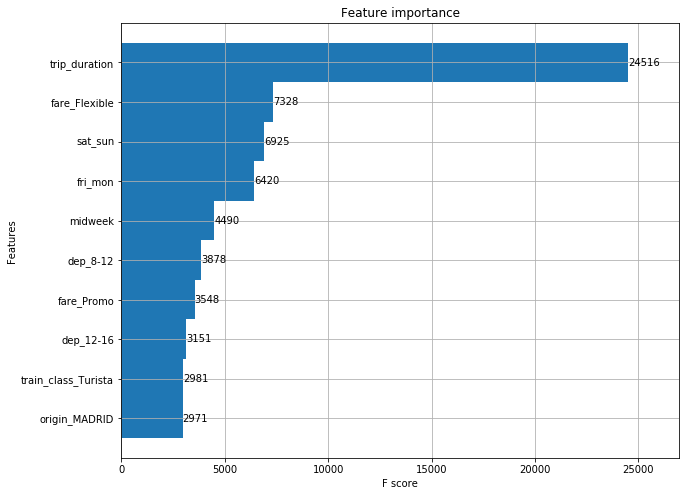

In [199]:
# Feature importance plot for XGBRegressor
fig, axes = plt.subplots(figsize=(10, 8))
xgb.plot_importance(xgb_reg, ax=axes, height=1, max_num_features=10)
plt.show()

We'll just go through this plot, one by one, evaluating against our 'price' variable to see if we can improve the interpretability of our XGBoost model.

To start out though, we'll create a heatmap to see if there are any significant correlations with the 'price' column.

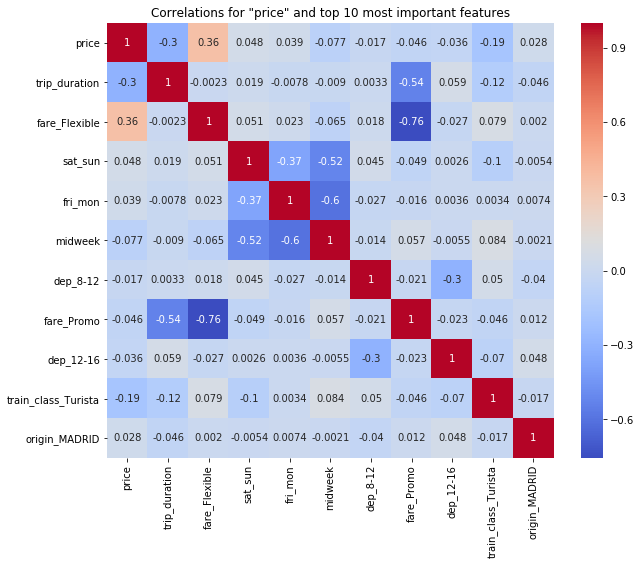

In [108]:
imp_feats = features[['price', 'trip_duration', 'fare_Flexible', 'sat_sun', 'fri_mon',
                     'midweek', 'dep_8-12', 'fare_Promo', 'dep_12-16', 'train_class_Turista',
                     'origin_MADRID']].copy()

plt.figure(figsize=(10, 8))
sns.heatmap(imp_feats.corr(), cmap='coolwarm', annot=True)
plt.title('Correlations for "price" and top 10 most important features')
plt.show()

Looking specifically at the correlations along the __price__ row/column, we see that there are only 3 mild correlations: a weak positive correlation with __fare_Flexible__, and weak negative correlations with __trip_duration__ and __train_class_Turista__.

From here we can move on to the bivariate comparisons.

#### trip_duration

For continuity, I'll recreate the visualization from our EDA at the beginning of the project showing the weak relationship petween price and trip_duration.

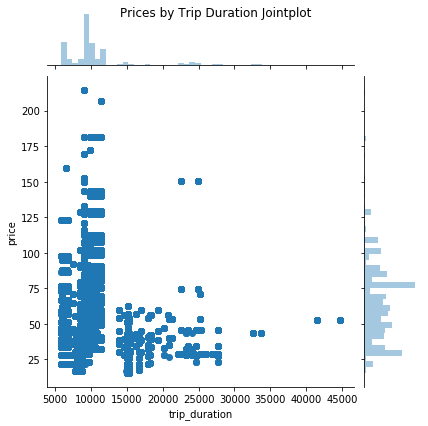

correlation coefficient: -0.2967237585821644


In [116]:
sns.jointplot(x='trip_duration', y='price', data=features)
plt.suptitle('Prices by Trip Duration Jointplot')
plt.show()

print('correlation coefficient:', features['price'].corr(features['trip_duration']))

It's a weak negative correlation, and being the highest among the feature importance ranking, it can only go down from here. But, we may also see that the correlation coefficient is not the sole factor in determining a feature's predictive power.

#### fare_Flexible

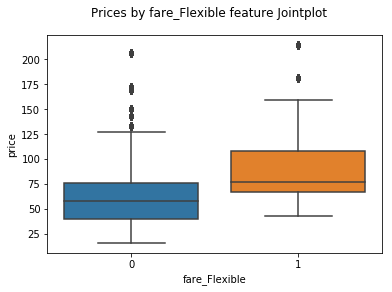

T-test for independent sample means:


Ttest_indResult(statistic=-590.2530146219468, pvalue=0.0)

In [190]:
sns.boxplot(x='fare_Flexible', y='price', data=features)
plt.suptitle('Prices by fare_Flexible feature Jointplot')
plt.show()

print("T-test for independent sample means:")
ttest_ind(features[features['fare_Flexible']==0]['price'],
          features[features['fare_Flexible']==1]['price'])

Again, a weak correlation, this time positive. It appears, however, that the IQR for fare_Flexible==1 is almost identical to fare_Flexible==0 increased by about 25 Euros. The median values are closer than this.

Flexible fares come with benefits: they are fully refundable and offer seat choice. The upcharge to make a fare flexible may be a set price.

Our T-test shows that the means are not the same.

#### sat_sun

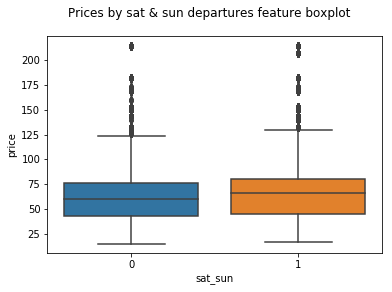

T-test for independent sample means:


Ttest_indResult(statistic=-72.99485944169244, pvalue=0.0)

In [191]:
sns.boxplot(x='sat_sun', y='price', data=features)
plt.suptitle('Prices by sat & sun departures feature boxplot')
plt.show()

print("T-test for independent sample means:")
ttest_ind(features[features['sat_sun']==0]['price'],
          features[features['sat_sun']==1]['price'])

We have a very weak positive correlation here, but it's possible to see a slight increase in price of sat_sun==1 over sat_sun==0. It will be interesting to see what the other day groupings show as we continue. Again, the T-test shows that we must reject a null hypothesis that the means are the same.

#### fri_mon

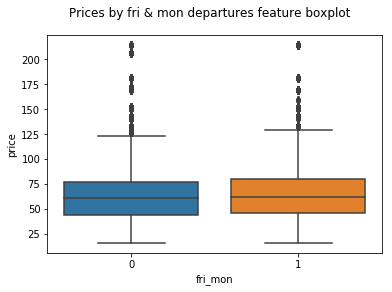

T-test for independent sample means:


Ttest_indResult(statistic=-58.34122914200193, pvalue=0.0)

In [192]:
sns.boxplot(x='fri_mon', y='price', data=features)
plt.suptitle('Prices by fri & mon departures feature boxplot')
plt.show()

print("T-test for independent sample means:")
ttest_ind(features[features['fri_mon']==0]['price'],
          features[features['fri_mon']==1]['price'])

Again a very weak positive correlation. There's hardly any visual difference between the two aside from the outlier distribution. The t-statistic is slightly larger than in the 'sat_sun' column, but still not significant.

#### midweek

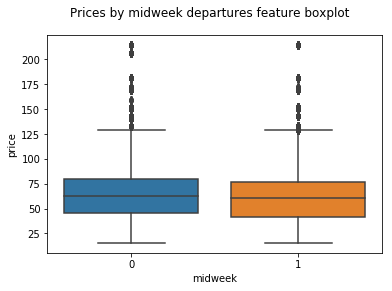

T-test for independent sample means:


Ttest_indResult(statistic=116.88949085292192, pvalue=0.0)

In [193]:
sns.boxplot(x='midweek', y='price', data=features)
plt.suptitle('Prices by midweek departures feature boxplot')
plt.show()

print("T-test for independent sample means:")
ttest_ind(features[features['midweek']==0]['price'],
          features[features['midweek']==1]['price'])

As could be expected from the other two weekday divisions, the midweek trips tend toward slightly cheaper ticket prices. It's a very weak association, but at least it follows a common sense analysis. Our T-test shows again that we cannot accept a null hypothesis where the means are the same.

#### dep_8-12 (departures between 8am and 12pm)

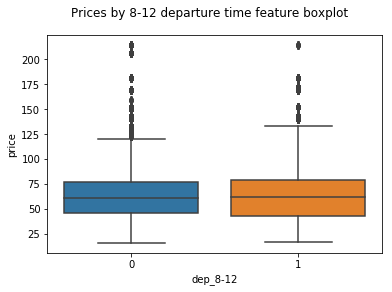

T-test for independent sample means:


Ttest_indResult(statistic=26.110404226216883, pvalue=2.92390863627067e-150)

In [194]:
sns.boxplot(x='dep_8-12', y='price', data=features)
plt.suptitle('Prices by 8-12 departure time feature boxplot')
plt.show()

print("T-test for independent sample means:")
ttest_ind(features[features['dep_8-12']==0]['price'],
          features[features['dep_8-12']==1]['price'])

Here I was expecting to perhaps see a positive relationship, as people might be taking the train to work and rush fares are typically higher, but this is not the case. While our p-value is above 0.0, it is still below a 0.05 level of significance, and thus, we'll reject the hypothesis of equal means.

#### fare_Promo

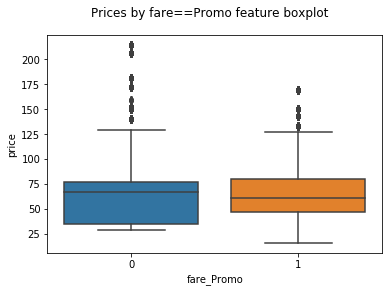

T-test for independent sample means:


Ttest_indResult(statistic=69.9324089398403, pvalue=0.0)

In [195]:
sns.boxplot(x='fare_Promo', y='price', data=features)
plt.suptitle('Prices by fare==Promo feature boxplot')
plt.show()

print("T-test for independent sample means:")
ttest_ind(features[features['fare_Promo']==0]['price'],
          features[features['fare_Promo']==1]['price'])

We can see that the boxplots look quite different, whisker length, box size, and median. We also will reject the null hypothesis of equal means, so we can say the means have some difference as well.

#### dep_12-16 (departures between 12pm and 4pm)

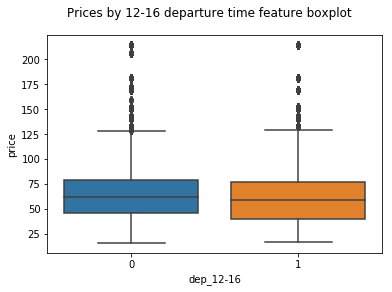

T-test for independent sample means:


Ttest_indResult(statistic=54.63225992407432, pvalue=0.0)

In [196]:
sns.boxplot(x='dep_12-16', y='price', data=features)
plt.suptitle('Prices by 12-16 departure time feature boxplot')
plt.show()

print("T-test for independent sample means:")
ttest_ind(features[features['dep_12-16']==0]['price'],
          features[features['dep_12-16']==1]['price'])

The boxplot makes it look like a weak negative relationship between the fare prices and departures between noon and 4pm. Midday fares are probably cheaper than high volume rush hours. Again, we reject the null hypothesis, the mean ticket prices between 12-4pm fares and others are not equal.

#### train_class_Turista

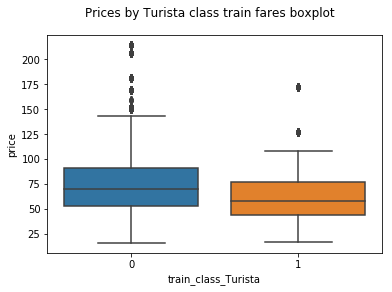

T-test for independent sample means:


Ttest_indResult(statistic=284.45416378969156, pvalue=0.0)

In [197]:
sns.boxplot(x='train_class_Turista', y='price', data=features)
plt.suptitle('Prices by Turista class train fares boxplot')
plt.show()

print("T-test for independent sample means:")
ttest_ind(features[features['train_class_Turista']==0]['price'],
          features[features['train_class_Turista']==1]['price'])

Turista is basically the economy class, so it's a bit of a given that it's going to correlate with lower prices. The boxplot validates this, as does out T-test, that the means are not equal.

#### origin_MADRID

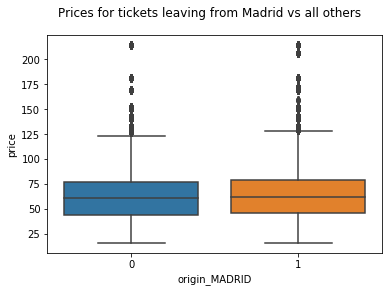

T-test for independent sample means:


Ttest_indResult(statistic=-41.584370317596616, pvalue=0.0)

In [198]:
sns.boxplot(x='origin_MADRID', y='price', data=features)
plt.suptitle('Prices for tickets leaving from Madrid vs all others')
plt.show()

print("T-test for independent sample means:")
ttest_ind(features[features['origin_MADRID']==0]['price'],
          features[features['origin_MADRID']==1]['price'])

All we can really tell from this is that the means are not equal. This plot isn't telling us a lot, and I have a feeling that the feature importance for origin_MADRID is reflecting the dominance of this origin city over others (as was seen in the countplots during EDA). I want to extend our feature importance list and see where the next most popular city, Barcelona, shows up.

In [158]:
feat_importance_df = pd.DataFrame(list(xgb_reg.get_booster().get_fscore().items()),
                                 columns=['feature', 'importance']).sort_values('importance',
                                                                          ascending=False)
feat_importance_df.head(15)

,feature,importance
0,trip_duration,24516
1,fare_Flexible,7328
24,sat_sun,6925
5,fri_mon,6420
6,midweek,4490
7,dep_8-12,3878
27,fare_Promo,3548
21,dep_12-16,3151
30,train_class_Turista,2981
9,origin_MADRID,2971


origin_BARCELONA appears as the 15th most important feature in our model. Perhaps a more balanced method for approaching __origin__ would be to group the remaining 3 cities (Ponferrada, Sevilla, and Valencia) together to create 3 outcomes for this feature.

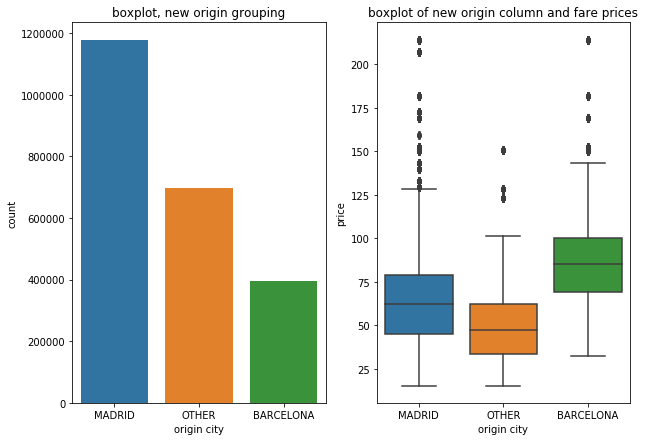

ANOVA test of origin2 column


F_onewayResult(statistic=284775.88284425123, pvalue=0.0)

In [187]:
data['origin2'] = data['origin'].where((data['origin']=='MADRID') | (data['origin']=='BARCELONA'), 'OTHER')

plt.subplots(figsize=(10, 7))

plt.subplot(1, 2, 1)
sns.countplot(x='origin2', data=data)
plt.title("boxplot, new origin grouping")
plt.xlabel('origin city')

plt.subplot(1, 2, 2)
sns.boxplot(x='origin2', y='price', data=data)
plt.title('boxplot of new origin column and fare prices')
plt.xlabel("origin city")

plt.show()

print('ANOVA test of origin2 column')
f_oneway(data[data['origin2']=='MADRID']['price'],
         data[data['origin2']=='BARCELONA']['price'],
         data[data['origin2']=='OTHER']['price'])

This appears like it could be a helpful grouping - OTHER is well-populated and shows fewer outliers on the right-hand plot while also looking more consistent with the size and IQR of the MADRID and BARCELONA boxplots. None of the groups have the same mean from the ANOVA, which is also important, as they'll tell us different things.

## _Final Analysis and Interpretation_

After testing out a few models, our best model is actually a tie between RandomForestRegressor and XGBoost. While they both achieved an RMSLE value of 0.14, I would ultimately choose XGBoost. When translating our results back to a business expert, feature importance is one of the most tangible findings of this project, and XGBoost has a very easy, built-in method for visualizing that.

Speaking of feature importance, we could see that trip duration, day of the week, flexible and promo fares, and Turista class trains are some of the features that tell us the most about fare prices. 

One of the first areas I would expand this project is a further exploration of the hour groupings. To do this, I would start by creating a multiple boxplot with a box for each one hour increment. This way, you could see if the data naturally splits itself in a way that may perform better. It may also improve the accuracy to perform the same kind of analysis of each day of the week to see if our 3 groupings are in fact ideal.

Other areas of improvement are treatment of outliers (we could apply winsorizing), feature reduction using principal component analysis, and expanded hyperparameter tuning to try and squeeze any additional performance out of our model.

In [23]:
X_train_subset = X_train.iloc[:(X_train.shape[0]//100), :]
X_train_subset.shape

(18152, 46)

In [24]:
Y_train_subset = Y_train.iloc[:(Y_train.shape[0]//100)]
Y_train_subset.shape

(18152,)

In [ ]:
mlp_params = {'hidden_layer_sizes' : [(1000,), (10000,), (100, 10), (1000, 10)],
              'activation' : ['relu', 'logistic'],
              'n_iter_no_change' : [10, 50],
              'learning_rate' : ['constant', 'adaptive'],
              'learning_rate_init' : [.001]}

In [ ]:
hidden_layer_params = {'hidden_layer_sizes' : [(100), (1000,), (10000,), (100, 10), 
                                                   (1000, 10), (100, 100), (1000, 100)],}
    
mlp_grid = GridSearchCV(estimator=MLPRegressor(early_stopping=True), 
                        param_grid=hidden_layer_params, cv=3, n_jobs=-2, verbose=2)

mlp_grid.fit(X_train, Y_train)

Fitting 3 folds for each of 7 candidates, totalling 21 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 3 concurrent workers.


In [26]:
mlp_grid.best_params_

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [54]:
mlp_model = MLPRegressor(hidden_layer_sizes=(100,), n_iter_no_change=10, early_stopping=True,
                         solver='adam', activation='logistic')
mlp_model.fit(X_train, Y_train)
joblib.dump(mlp_model, 'sup_capstone_mlp.joblib')

MLPRegressor(activation='logistic', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=True, epsilon=1e-08,
             hidden_layer_sizes=(100,), learning_rate='constant',
             learning_rate_init=0.001, max_iter=200, momentum=0.9,
             n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
             random_state=None, shuffle=True, solver='adam', tol=0.0001,
             validation_fraction=0.1, verbose=False, warm_start=False)

In [55]:
mlp_model = joblib.load('sup_capstone_mlp.joblib')
y_pred = mlp_model.predict(X_test)
rmsle(Y_test, y_pred)

0.43085947724951773

Our Multi-Layer Perceptron model is performing slightly better than the Linear SVR model, but much worse than Random Forest Regressor or XGBoost. This corresponds to our predicted values being about 1.5 times larger than the actual values.